# Optimal Split Of Orders Across Liquidity Pools

In this notebook, we address the challenge of optimally distributing orders across dark pools to enhance trading efficiency and reduce market impact. Dark pools, which are private trading venues where large orders can be executed discreetly, offer key benefits such as minimizing price slippage and lowering market impact. However, effectively managing order allocation across multiple dark pools is a complex problem that involves careful evaluation of liquidity, execution costs, and timing.

## Dark Pool Definitino / Modelling :

The principle of a Dark Pool is the following : 
- It proposes a bid price with no guarantee of executed quantity at the occasion of an OTC transaction.
- Usually this price is lower than the bid price offered on the regular market.

The impact of $N$ dark pools ($N>1$) on a given transaction can be modeled as follows : 
- $V>0$ be the random volume to be executed
- $\theta \in )0, 1($ be the discount factor proposed by the dark pool $i$.
- $r_i$ denote the percentage $V$ sent to the dark pool $i$ for execution
- $D_i \geq 0$ the quantity of securities that can be delivered (or mase available) by the dark pool $i$ at the dicounted price $\theta_i S$

The reminder of the order is to be executed on the regular market, at price $S$. 

## Cost of the executed order

The **cost** of the whole executed order across the $N$ dark pools is then given by : 



$$C = S \sum_{i=1}^{N} \theta_i \min(r_i V, D_i) + S \left( V - \sum_{i=1}^{N} \min(r_i V, D_i) \right)$$


$$= S \left( V - \sum_{i=1}^{N} \rho_i \min(r_i V, D_i) \right)$$

where

$$\rho_i = 1 - \theta_i \in (0,1), \quad i = 1, \dots, N$$

## Maximization Problem


**Minimizing the mean execution cost**, *given the price $S$*, amounts to solving the following **maximization problem**:


$$\max \left\{ \sum_{i=1}^{N} \rho_i \mathbb{E}(S \min(r_i V, D_i)), r \in \mathcal{P}_N \right\}$$

where

$$\mathcal{P}_N := \left\{ r = (r_i)_{1 \leq i \leq N} \in \mathbb{R}_+^N \mid \sum_{i=1}^{N} r_i = 1 \right\}$$

It is then convenient to include the price *$S$ into both random variables $V$ and $D_i$* by considering:


$$\widetilde{V} := V S \quad \text{and} \quad \widetilde{D_i} := D_i S$$

instead of $V$ and $D_i$.

## Resolution - Optimal allocation of orders among N dark pools


We set for every $r = (r_1, \dots, r_N) \in \mathcal{P}_N$,


$$\Phi(r_1, \dots, r_N) :=\sum_{i=1}^{N} \varphi_i(r_i)$$

where for every $i \in I_N = \{1, \dots, N\}$,


$$\varphi_i(u) := \rho_i \mathbb{E}[\min(u V, D_i)], \quad u \in [0,1]$$

We can formally extend $\Phi$ on the whole affine hyperplane spanned by $\mathcal{P}_N$, i.e.,


$$\mathcal{H}_N := \left\{ r = (r_1, \dots, r_N) \in \mathbb{R}^N \mid \sum_{i=1}^{N} r_i = 1 \right\}$$





In [287]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression

We deel with of period of 21 days and we have 4 markets : 
- Total our liquidity security
- LVMH, Bouygues and Sanofi our 3 Dark Pools

In [288]:
start_date = "2011-07-01"
end_date = "2011-07-31"

data_folder = "StockData/"
files = os.listdir(data_folder)
DATAS = {}
for f in files:
    name_company = f.replace(".h5","").lower()
    DATAS[name_company] = pd.read_hdf(data_folder+f)
    DATAS[name_company] = DATAS[name_company][(DATAS[name_company].index > pd.to_datetime(start_date))
                                               & (DATAS[name_company].index < pd.to_datetime(end_date))]
    # DATAS[name_company] = DATAS[name_company].fillna(0)

liquidity_security = 'lvmh'
dark_pools = ['bouygues', 'sanofi', 'total']
DATAS[liquidity_security].head()


,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign
Time,,,,,,,
2011-07-01 09:00:01.149,123.0,6,122.8,123.0,600000,100000,1
2011-07-01 09:00:01.149,123.0,48,122.8,123.0,600000,100000,1
2011-07-01 09:00:01.149,123.0,12,122.8,123.0,600000,100000,1
2011-07-01 09:00:01.149,123.0,10,122.8,123.0,600000,100000,1
2011-07-01 09:00:01.149,123.0,1,122.8,123.0,600000,100000,1


### Computation of the available volume for each Dark Pool

The available of each Dark Pool $i$ is modeled as follows :
$$ D_i = \beta_i \left((1-\alpha_i)V + \alpha_i S_i \frac{\mathbb{E}[V]}{\mathbb{E}[S_i]}\right) $$

where :
- $\alpha_i \in (0,1), \quad i = 1, \dots, N$ are the recombining coefficients,
- $\beta_i, \quad i = 1, \dots, N$ are some scaling factors,
- $\mathbb{E}[V]$ is the empirical mean of the liquidity security and $\mathbb{E}[S_i]$ is for the empirical mean of the data sets of $S_i$.

Firstly, we compute $\mathbb{E}[V]$ and $\mathbb{E}[S_i]$ and secondly, we compute the volume $D_i$ every 5 minutes

In [289]:
alpha_beta_rho = {}

alpha_beta_rho['bouygues'] = [0.4,0.1, 0.01]
alpha_beta_rho['sanofi'] =  [0.6,0.2, 0.02]
alpha_beta_rho['total'] = [0.8,0.2, 0.04]

In [290]:
T = "5Min" # it is our stochastic gradient period
mean_dark_pool = {}
mean_V = DATAS[liquidity_security]['BidQty'].resample(T).last().dropna().mean()

for market in dark_pools:
    mean_dark_pool[market] = DATAS[market]['BidPrice'].resample(T).last().dropna().mean()

In [291]:
liquidity_security_volume = DATAS[liquidity_security]['BidQty'].resample(T).last().dropna()
liquidity_security_price = DATAS[liquidity_security]['BidPrice'].resample(T).last().dropna()


D = {}

for market in dark_pools:
    alpha, beta, rho = alpha_beta_rho[market][0], alpha_beta_rho[market][1], alpha_beta_rho[market][2] 
    D[market] = beta * ((1 - alpha) * DATAS[liquidity_security]['BidQty'].resample(T).last() 
                        + alpha * DATAS[market]['BidPrice'].resample(T).last()* mean_V / mean_dark_pool[market])
    D[market] = D[market].dropna()

In [292]:
dates_df1 = set(D['sanofi'].index)
dates_df2 = set(D['total'].index)
dates_df3 = set(D['bouygues'].index)

# Identifier les dates présentes dans df1 et df2 mais absentes dans df3
common_dates_df1_df2 = dates_df1 & dates_df2  # Dates communes à df1 et df2
dates_not_in_df3 = common_dates_df1_df2 - dates_df3  # Dates présentes dans df1 et df2 mais pas dans df3

for date in dates_not_in_df3:
    D['bouygues'].loc[date] = 0
    D['bouygues'] = D['bouygues'].sort_index()

dates_df1 = set(D['sanofi'].index)
dates_df2 = set(D['total'].index)
dates_df3 = set(D['bouygues'].index)

# Identifier les dates présentes dans df1 et df2 mais absentes dans df3
common_dates_df1_df2 = dates_df1 & dates_df2  # Dates communes à df1 et df2
dates_not_in_df3 = common_dates_df1_df2 - dates_df3  # Dates présentes dans df1 et df2 mais pas dans df3


for market in dark_pools:
    D[market] = D[market].to_numpy()

In [293]:
for market in D:
    print(len(D[market]))

print(D['bouygues'][D['bouygues'] == 0])

2142
2142
2142
[0.]


### The oracle algorithm

Now we define a reference strategy named “oracle” devised by an insider who knows all the values $V_n$ and $D_{n,i}$ before making his/her optimal execution requests to the dark pools. The “oracle” strategy yields a cost reduction of the execution denoted by $CR^{oracle}$.

We introduce indexes to measure the performances of our recursive allocation procedure as follows: the ratios between the relative cost reductions of our allocation algorithm and that of the oracle : 
$$\frac{CR^{opti}}{CR^{oracle}}$$

Now we want to compare the Stochastic Algorithm with an Oracle Algorithm. We will implement the two algorithms to determine our repartition across the Dark Pools $r = (r_i)_{i=1,...,N}$ : 

- **Stochastic Algorithm** : to compute $r_n$ at each step $n$, we use $r_{n-1}$ to place an order composed of a fraction of V. The composition $r_{n-1}$ is updated to the new capacities of the Dark Pool at time $n$ thanks to a gradient descent describe previously.

- **Oracle Algorithm** : to compute $r_n$ at each step $n$, we calculate the best composition $r_n$ to place an order of volume $V$. The difference here is that Oracle knows the new capaities of the Dark Pool at time $n$ and then does not have information issues.

### Stochastic Algorithm

/var/folders/ly/ylvnx_l518x5nbt0ssvchqww0000gn/T/ipykernel_43218/3301961033.py:24: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  cost_n = liquidity_security_price[n] * (V - np.sum(alpha_beta_rho[market][2] * min(r_sto[market][-1]*V, int(D[market][n])) for market in dark_pools))


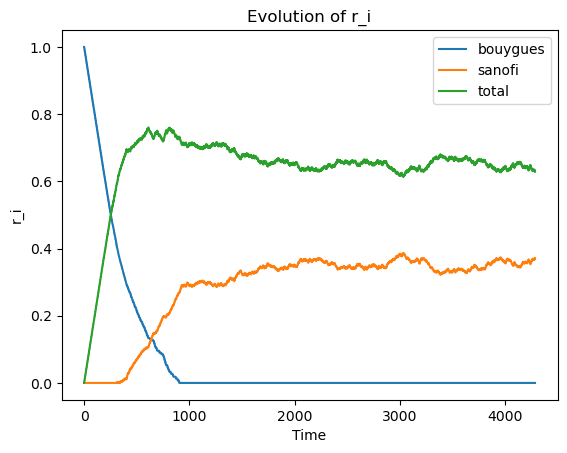

In [294]:
N = len(dark_pools)
V = 20000
learning_rate = 0.00001

r_sto = {}

H = {}
r_sto[dark_pools[0]] = [1]

for market in dark_pools:
    if market not in r_sto :
        r_sto[market] = [0.0]
    H[market] = []
    
cost_sto = []
for n in range(len(D[dark_pools[0]])-1):
    for market in dark_pools : 
        r_sto[market].append(np.clip(r_sto[market][-1], 0, 1))
    sum_r = sum(r_sto[market][-1] for market in dark_pools)

    for market in dark_pools : 
        r_sto[market][-1] = r_sto[market][-1] / sum_r

    cost_n = liquidity_security_price[n] * (V - np.sum(alpha_beta_rho[market][2] * min(r_sto[market][-1]*V, int(D[market][n])) for market in dark_pools))
    cost_sto.append(cost_n)
    
    for market in dark_pools : 
        H[market].append(V * (alpha_beta_rho[market][2] * (r_sto[market][-1]*V < D[market][n]) - 
                              (1/N) * np.sum([alpha_beta_rho[every_market][2]*(r_sto[every_market][-1]*V < D[every_market][n]) for every_market in dark_pools])))
        
        r_new_market = r_sto[market][-1] + learning_rate * H[market][-1]
        r_new_market = np.clip(r_new_market, 0, 1)
        r_sto[market].append(r_new_market)
    

for market in dark_pools: 
    plt.plot(r_sto[market], label = market)
    
plt.title("Evolution of r_i")
plt.xlabel("Time")
plt.ylabel("r_i")
plt.legend()
plt.show()               

We observe that the composition $(r_n)_n = (r_{i,n})_n$ converges (with some noise) to some values that are in the same order than $\rho_i$:

### Oracle algorithm

In this scenario, we are aware of the capacities of the dark pools in advance, allowing us to determine the optimal allocation for purchasing a given volume.

Specifically, we start by buying the maximum number of LVMH shares from the dark pool with the highest capacity, then proceed to the pool with the second highest capacity, and continue this process until we have acquired the desired number of shares. If the required volume exceeds the total capacity of the dark pools, the remaining shares are bought on the regular market.

This results in:

In [295]:
r_oracle = {}
for market in dark_pools:
    r_oracle[market] = []
cost_oracle = []

for n in range (len(D[dark_pools[0]])-1):

    remaining_volume = V
    DP_volumes = {}
    sorted_rhos = []
    for market in dark_pools:
        DP_volumes[market] = D[market][n]
        sorted_rhos.append(alpha_beta_rho[market][2])
    
    executed_quantity = {market: 0 for market in dark_pools}#[0, 0, 0]
    for market in dark_pools[::-1]:
        if DP_volumes[market] < remaining_volume:
            executed_quantity[market] = DP_volumes[market]
            remaining_volume -= DP_volumes[market]
        else:
            executed_quantity[market] = remaining_volume
            remaining_volume = 0

    
    for market in dark_pools : 
        r_oracle[market].append(executed_quantity[market] / V)

    cost = liquidity_security_price[n] * (V - np.sum([sorted_rhos[j] * min(executed_quantity[market], DP_volumes[market]) for j, market in enumerate(dark_pools)]))
    cost_oracle.append(cost)

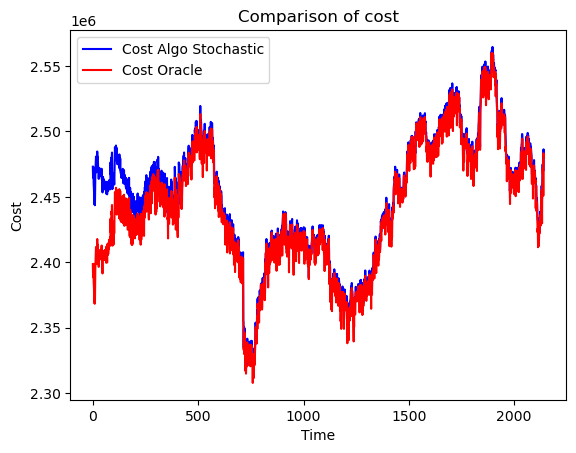

In [296]:
plt.plot(cost_sto, color='blue', label='Cost Algo Stochastic')
plt.plot(cost_oracle, color='red', label= 'Cost Oracle')
plt.title("Comparison of cost")
plt.xlabel("Time")
plt.ylabel("Cost")
plt.legend()
plt.show()

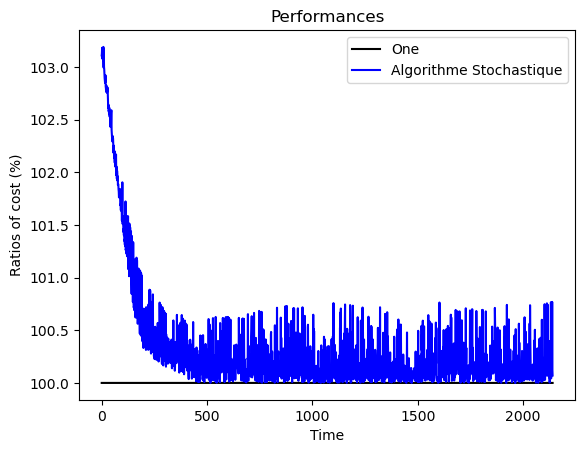

In [297]:
cost_ref = 100 * np.ones(len(cost_oracle))
relative_cost = (np.array(cost_sto)/np.array(cost_oracle))*100

plt.plot(cost_ref, color='black', label='One')
plt.plot(range(len(relative_cost)), relative_cost, color='blue', label='Algorithme Stochastique')
plt.xlabel("Time")
plt.ylabel("Ratios of cost (%)")
plt.title("Performances")
plt.legend()
plt.show()

The stochastic algorithm is a good algorithm to approach the performances of the Oracle algorithm but it still have some noises.

# Conclusion

In this notebook, we tackled the challenge of optimally distributing orders between dark pools and the regular market using a stochastic algorithm. We compared the algorithm's performance to that of an omniscient agent, who knows the dark pool capacities in advance for the next trading date. Overall, the stochastic algorithm effectively achieves an efficient order allocation across the various liquidity pools.